<a href="https://colab.research.google.com/github/veiro/master-tesis-data-imputation/blob/master/prediccion/Prueba_de_prediccion_categorico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo:
Utilizar tecnicas de ml para prededir 2 atributos: uno categorico y otro numerico.

Obtener metricas de que tan bien funciona para la prediccion en el dataset - original.

# Trabajo en siguiente iteracion
Luego de hacer imputacion de datos con los algoritmos GAIN y MIDA se obtiene el dataset-GAIN y dataset-MIDA.

Se va a comporar las metricas de prediccion en:
- dataset - original.
- dataset-GAIN
- dataset-MIDA

# Configuracion ambiente

In [1]:
!pip install ydata-profiling

In [2]:
!pip install pycaret
#https://pycaret.gitbook.io/docs/get-started/tutorials

In [3]:
import os
import sys

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import pandas
from sklearn.model_selection import train_test_split
from google.colab import drive
from ydata_profiling import ProfileReport

from datetime import datetime


In [4]:
USAR_GOOGLE_DRIVE =  True
MODO_DESARROLLO = True

# Preprocesamiento datos

In [5]:
if (USAR_GOOGLE_DRIVE):
  drive.mount('/content/gdrive')
  PATH_DATA_PROCESADA = "/content/gdrive/MyDrive/Maestria/Tesis/Codigo/data/data-procesada"
else:
  PATH_DATA_PROCESADA = "PONER LA RUTA"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
%%time
data_filepath = PATH_DATA_PROCESADA+'/csse_covid_19_data.csv'
data_full = pandas.read_csv(data_filepath)


CPU times: user 10.4 s, sys: 2.17 s, total: 12.6 s
Wall time: 24.7 s


In [7]:
%%time
data_sin_columnas_completas = data_full.drop(['FIPS', 'Admin2', 'Recovered', 'Active', 'Combined_Key'], axis=1)
data_sin_null = data_sin_columnas_completas.dropna(subset=['Province_State', 'Lat', 'Long_', 'Incident_Rate', 'Case_Fatality_Ratio'])


CPU times: user 1.38 s, sys: 278 ms, total: 1.66 s
Wall time: 5.39 s


In [8]:
report = ProfileReport(data_sin_null, minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Prediccion de un campo categorico

En base a los dato
(**Deaths	 Province_State	Last_Update	Lat	Long_	Confirmed		Incident_Rate	Case_Fatality_Ratio	date**) el objetivo es predecir **Country_Region**

------------

Basado en el tutorial https://colab.research.google.com/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Multiclass%20Classification.ipynb#scrollTo=4181de41&uniqifier=1

In [16]:
# para hacer pruebas bajo la cantidad
if(MODO_DESARROLLO):
   data =  data_sin_null.sample(n=10000, random_state=1)
else:
  data = data_sin_null

df_train, df_test = train_test_split(data, test_size=0.30, random_state=42)

In [17]:
%%time
from pycaret.classification import *
s = setup(data, target = 'Country_Region', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Country_Region
2,Target type,Multiclass
3,Target mapping,"Australia: 0, Belgium: 1, Brazil: 2, Canada: 3, Chile: 4, China: 5, Colombia: 6, Denmark: 7, France: 8, Germany: 9, India: 10, Italy: 11, Japan: 12, Malaysia: 13, Mexico: 14, Netherlands: 15, New Zealand: 16, Pakistan: 17, Peru: 18, Russia: 19, Spain: 20, Sweden: 21, US: 22, Ukraine: 23, United Kingdom: 24"
4,Original data shape,"(10000, 10)"
5,Transformed data shape,"(10000, 10)"
6,Transformed train set shape,"(7000, 10)"
7,Transformed test set shape,"(3000, 10)"
8,Numeric features,6
9,Categorical features,3


CPU times: user 1.56 s, sys: 22.7 ms, total: 1.59 s
Wall time: 1.61 s


In [18]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9896,0.0000,0.9896,0.9917,0.9893,0.9603,0.9604,1.6500
rf,Random Forest Classifier,0.9887,0.0000,0.9887,0.9906,0.9881,0.9566,0.9568,1.1910
gbc,Gradient Boosting Classifier,0.9846,0.0000,0.9846,0.9882,0.9845,0.9409,0.9411,40.4600
et,Extra Trees Classifier,0.9837,0.0000,0.9837,0.9860,0.9826,0.9372,0.9375,0.4390
dt,Decision Tree Classifier,0.9760,0.0000,0.9760,0.9888,0.9786,0.9085,0.9091,0.2770
lda,Linear Discriminant Analysis,0.9611,0.0000,0.9611,0.9707,0.9616,0.8551,0.8558,0.1370
nb,Naive Bayes,0.9234,0.0000,0.9234,0.9351,0.9206,0.7086,0.7097,0.2770
ridge,Ridge Classifier,0.8950,0.0000,0.8950,0.8480,0.8661,0.5106,0.5307,0.1300
ada,Ada Boost Classifier,0.8853,0.0000,0.8853,0.8571,0.8649,0.5502,0.5619,0.9000
lr,Logistic Regression,0.8710,0.0000,0.8710,0.8133,0.8392,0.3746,0.3970,5.4580


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

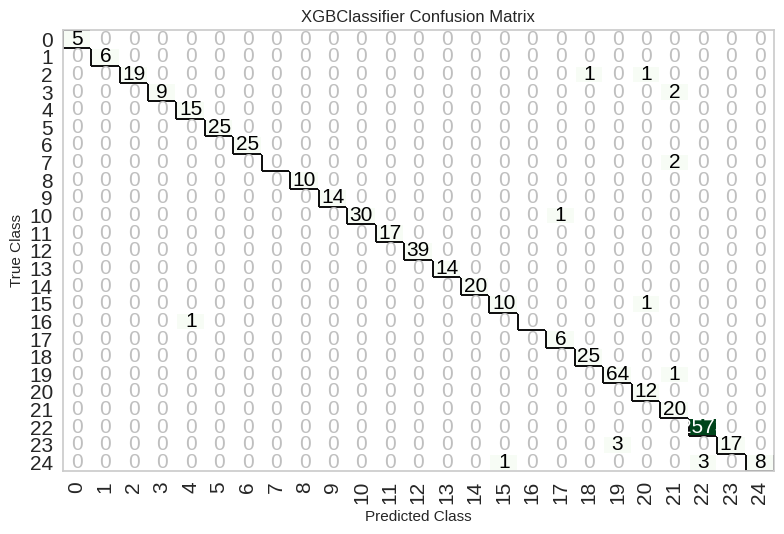

In [19]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

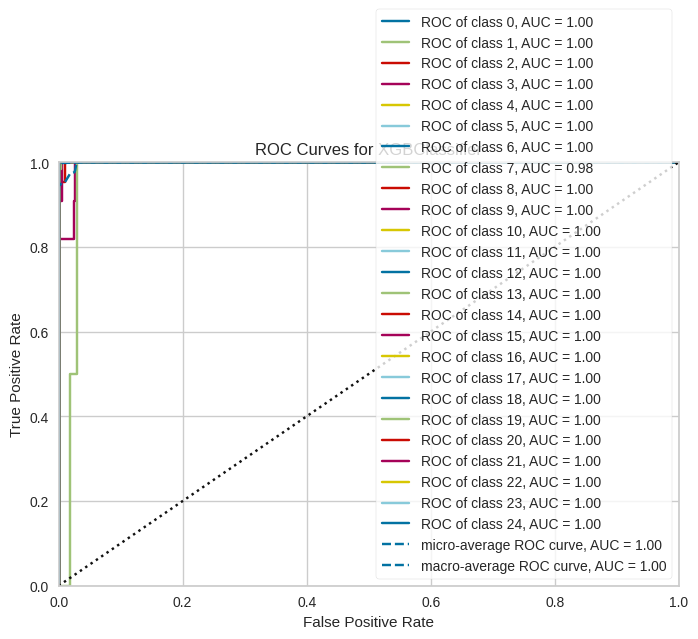

In [20]:
# plot AUC
plot_model(best, plot = 'auc')

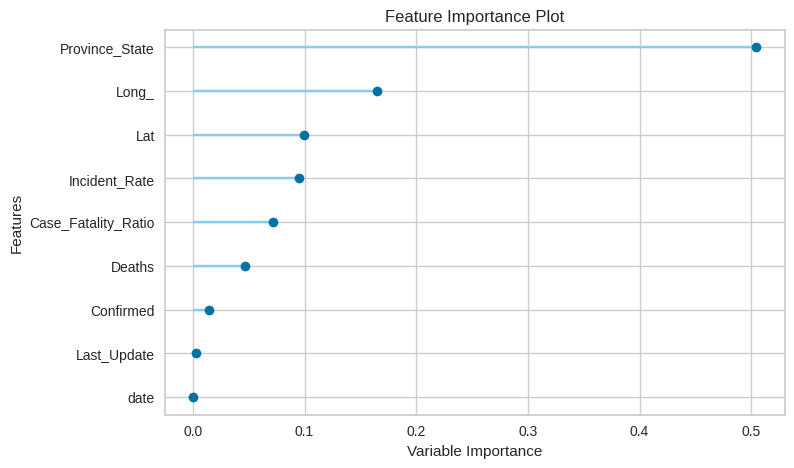

In [21]:
# plot feature importance
plot_model(best, plot = 'feature')

In [22]:
# predict on test set
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9943,1.0000,0.9943,0.9939,0.9938,0.9784,0.9784


In [23]:
# show predictions df
holdout_pred.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio,date,Country_Region,prediction_label,prediction_score
301809,Arkansas,2021-03-17 05:25:07,36.096039,-91.908478,1646,41,12077.188477,2.490887,03-16-2021,22,US,1.0000
2493160,West Virginia,2022-09-13 04:20:57,39.285385,-80.379196,23986,265,35663.734375,1.104811,09-12-2022,22,US,1.0000
1806671,Distrito Federal,2022-03-27 04:20:47,-15.799800,-47.864498,691353,11573,22928.410156,1.673964,03-26-2022,2,Brazil,0.9970
1650262,Jammu and Kashmir,2022-02-16 04:21:10,33.759430,76.612640,451330,4745,3317.061523,1.051337,02-15-2022,10,Pakistan,0.3631
1786523,Scotland,2022-03-21 04:20:50,56.490700,-4.202600,1663830,13847,30454.669922,0.667015,03-20-2022,24,United Kingdom,0.9831


In [24]:
# predict model on new_data
predictions = predict_model(best, data = df_test)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9980,1.0000,0.9980,0.9978,0.9978,0.9925,0.9925


,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio,date,Country_Region,prediction_label,prediction_score
2139591,Virginia,2022-06-17 04:20:56,37.481335,-80.210724,1155,19,22510.232422,1.645022,06-16-2022,22,US,1.0000
1221534,Idaho,2021-11-01 04:22:01,42.282696,-111.328926,698,13,11395.917969,1.862464,10-31-2021,22,US,1.0000
1638440,Cajamarca,2022-02-13 04:21:00,-6.430284,-78.745598,91844,4292,6317.947266,4.673141,02-12-2022,18,Peru,0.9971
2213422,Georgia,2022-07-06 04:20:58,32.509319,-84.871422,39655,838,20256.015625,2.113227,07-05-2022,22,US,1.0000
2883965,Florida,2022-12-20 04:21:04,27.077208,-80.431099,38932,732,24181.367188,1.880201,12-19-2022,22,US,1.0000


In [25]:
now = datetime.now()
time = now.strftime("%H:%M:%S")

ruta_modelo = PATH_DATA_PROCESADA + '/modelo_prediccion/' + 'clsificacion_Country_Region_'+time
save_model(best, ruta_modelo)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Lat', 'Long_', 'Confirmed',
                                              'Deaths', 'Incident_Rate',
                                              'Case_Fatality_Ratio'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value...
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                                max_bin=None, max_cat_threshold=None,
                     

In [26]:
# load pipeline
loaded_best_pipeline = load_model(ruta_modelo)
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Lat', 'Long_', 'Confirmed',
                                             'Deaths', 'Incident_Rate',
                                             'Case_Fatality_Ratio'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))],
         verbose=False)